Trajectory 0: 31 residues, 258 atoms
Trajectory 1: 31 residues, 258 atoms
Trajectory 2: 31 residues, 258 atoms
RMSF result shape for trajectory 0: (93,)
RMSF result shape for trajectory 1: (93,)
RMSF result shape for trajectory 2: (93,)


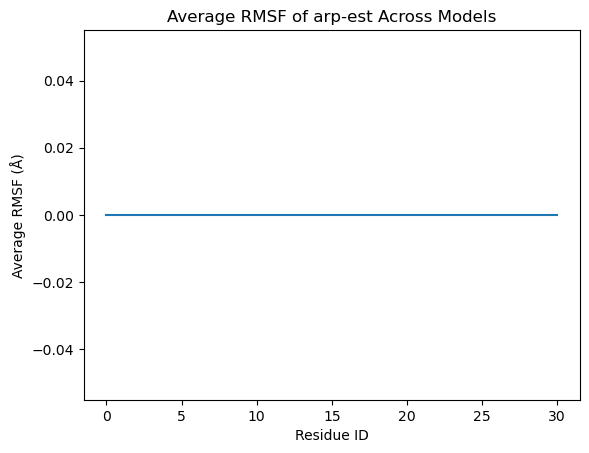

In [25]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt

# List of your PDB files
pdb_files = [
    '1V1D_5c7bb_0_unrelaxed_rank_001_alphafold2_ptm_model_4_seed_003.pdb',
    '1V1D_5c7bb_0_unrelaxed_rank_002_alphafold2_ptm_model_4_seed_005.pdb',
    '1V1D_5c7bb_0_unrelaxed_rank_040_alphafold2_ptm_model_5_seed_001.pdb'
]

# Load all PDB files into trajectories
trajs = [md.load(file) for file in pdb_files]

# Check the number of residues and atoms in each trajectory
for i, traj in enumerate(trajs):
    print(f"Trajectory {i}: {traj.n_residues} residues, {traj.n_atoms} atoms")

# Select backbone atoms (CA, N, C)
backbone_atoms = trajs[0].topology.select("name CA or name N or name C")

# Superpose all trajectories to the reference using backbone atoms
reference_traj = trajs[0]
for i, traj in enumerate(trajs):
    traj.superpose(reference_traj, atom_indices=backbone_atoms)

# Initialize an array to accumulate RMSF results
n_residues = trajs[0].n_residues
rmsf_values = np.zeros((n_residues, len(trajs)))

# Calculate RMSF for each trajectory using backbone atoms
for i, traj in enumerate(trajs):
    rmsf_result = md.rmsf(traj, reference_traj, atom_indices=backbone_atoms)
    
    print(f"RMSF result shape for trajectory {i}: {rmsf_result.shape}")
    
    # Initialize per-residue RMSF array
    rmsf_per_residue = np.zeros(n_residues)
    atom_counts = np.zeros(n_residues)

    # Average the RMSF per residue (using only backbone atoms)
    for j, atom in enumerate(backbone_atoms):  # j is the index in the backbone atom subset
        residue_index = traj.topology.atom(atom).residue.index
        if residue_index < n_residues:
            rmsf_per_residue[residue_index] += rmsf_result[j]
            atom_counts[residue_index] += 1

    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        rmsf_per_residue = np.divide(rmsf_per_residue, atom_counts, out=np.zeros_like(rmsf_per_residue), where=atom_counts!=0)
    
    # Store the per-residue RMSF result
    rmsf_values[:, i] = rmsf_per_residue

# Calculate the average RMSF across all trajectories
average_rmsf = np.mean(rmsf_values, axis=1)

# Plotting RMSF
plt.plot(range(len(average_rmsf)), average_rmsf)
plt.xlabel('Residue ID')
plt.ylabel('Average RMSF (Å)')
plt.title('Average RMSF of arp-est Across Models')
plt.show()
